In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers, Input, models, metrics

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [14]:
# 학습 데이터 셋을 이미지 증식 설정 하는 부분
train_datagen = ImageDataGenerator(rescale=1./255,              # 주어진 이미지 크기 설정(0 ~ 1 사이)
                                   horizontal_flip = True,      # 수평 대칭 이미지를 50% 확률로 만들어 추가
                                                                # 주어진 이미지 수평, 수직으로 뒤집어줌
                                   width_shift_range = 0.1,     # 전체 크기의 10% 범위 내에서 좌우로 이동
                                   height_shift_range = 0.1,    # 전체 크기의 10% 범위 내에서 상하로 이동
                                   rotation_range = 5,          # 정해진 각도(여기서는 5도) 만큼 회전
                                   shear_range = 0.7,           # 좌표 하나를 고정, 나머지 이동
                                   zoom_range = 1.2,            # 확대, 축소
                                   vertical_flip = True,        # 수직 대칭 이미지
                                   fill_mode = 'nearest')       # 빈 공간을 채움 nearest 옵션 : 가장 비슷한 색으로 채움

# 학습 데이터 셋이 있는 폴더 위치 지정
train_generator = train_datagen.flow_from_directory('./data/train/', target_size = (150, 150), 
                                                    batch_size = 5,
                                                    class_mode = 'binary')

Found 160 images belonging to 2 classes.


In [15]:
# 테스트 데이터 셋을 이미지 증식 설정 하는 부분
# 테스트 데이터 셋은 이미지 증식 안함
test_datagen = ImageDataGenerator(rescale=1./255)

In [16]:
test_generator = test_datagen.flow_from_directory('./data/test/', target_size = (150, 150), 
                                                    batch_size = 5,
                                                    class_mode = 'binary')

Found 120 images belonging to 2 classes.


In [17]:
# 모델링 (CNN)

model = Sequential()
model.add(Conv2D(32,(3,3), input_shape = (150, 150, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 activation_3 (Activation)   (None, 148, 148, 32)      0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 activation_4 (Activation)   (None, 72, 72, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                  

In [18]:
# 모델 컴파일
model.compile(loss = 'binary_crossentropy',
              optimizer = optimizers.Adam(learning_rate=0.0002), metrics = ['accuracy'])

# 학습 조기 중단
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience=5)

# 모델 실행
history = model.fit(
    train_generator, 
    epochs = 100, 
    validation_data = test_generator, 
    validation_steps = 10,
    callbacks = [early_stopping_callback]
    )

Epoch 1/100
32/32 [==============================] - 1s 23ms/step - loss: 0.7062 - accuracy: 0.5375 - val_loss: 0.6893 - val_accuracy: 0.5400
Epoch 2/100
32/32 [==============================] - 1s 18ms/step - loss: 0.6901 - accuracy: 0.5000 - val_loss: 0.7028 - val_accuracy: 0.4400
Epoch 3/100
32/32 [==============================] - 1s 18ms/step - loss: 0.6946 - accuracy: 0.5312 - val_loss: 0.6839 - val_accuracy: 0.5600
Epoch 4/100
32/32 [==============================] - 1s 17ms/step - loss: 0.6903 - accuracy: 0.5125 - val_loss: 0.6872 - val_accuracy: 0.5400
Epoch 5/100
32/32 [==============================] - 1s 17ms/step - loss: 0.6877 - accuracy: 0.5750 - val_loss: 0.6928 - val_accuracy: 0.4600
Epoch 6/100
32/32 [==============================] - 1s 17ms/step - loss: 0.6800 - accuracy: 0.5375 - val_loss: 0.6873 - val_accuracy: 0.4400
Epoch 7/100
32/32 [==============================] - 1s 17ms/step - loss: 0.6842 - accuracy: 0.5562 - val_loss: 0.6800 - val_accuracy: 0.4800
Epoch 

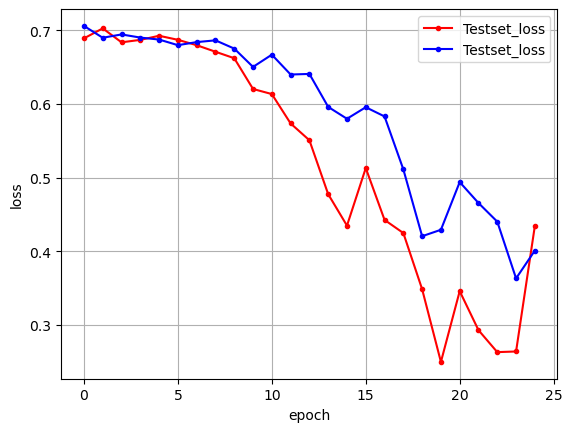

In [19]:
# 검증셋과 학습셋의 오차 저장

y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker = '.', c='red', label = 'Testset_loss')
plt.plot(x_len, y_loss, marker = '.', c='blue', label = 'Testset_loss')

plt.legend(loc = 'best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [20]:
# 전이 학습(Transfer Learning)

from tensorflow.keras.applications import VGG16

In [36]:
# 학습 데이터 셋을 이미지 증식 설정 하는 부분
train_datagen = ImageDataGenerator(rescale=1./255,              # 주어진 이미지 크기 설정(0 ~ 1 사이)
                                   horizontal_flip = True,      # 수평 대칭 이미지를 50% 확률로 만들어 추가
                                                                # 주어진 이미지 수평, 수직으로 뒤집어줌
                                   width_shift_range = 0.1,     # 전체 크기의 10% 범위 내에서 좌우로 이동
                                   height_shift_range = 0.1)    # 전체 크기의 10% 범위 내에서 상하로 이동
                                #    rotation_range = 5,          # 정해진 각도(여기서는 5도) 만큼 회전
                                #    shear_range = 0.7,           # 좌표 하나를 고정, 나머지 이동
                                #    zoom_range = 1.2,            # 확대, 축소
                                #    vertical_flip = True,        # 수직 대칭 이미지
                                #    fill_mode = 'nearest')       # 빈 공간을 채움 nearest 옵션 : 가장 비슷한 색으로 채움

# 학습 데이터 셋이 있는 폴더 위치 지정
train_generator = train_datagen.flow_from_directory('./data/train/', target_size = (150, 150), 
                                                    batch_size = 5,
                                                    class_mode = 'binary')

Found 160 images belonging to 2 classes.


In [37]:
# 모델링

# VGG16 불러오기

transfer_model = VGG16(weights = 'imagenet', include_top=False, input_shape = (150, 150, 3))
transfer_model.trainable = False
transfer_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [38]:
finetuen_model = Sequential()
finetuen_model.add(transfer_model)
finetuen_model.add(Flatten())
finetuen_model.add(Dense(64, activation = 'relu'))
finetuen_model.add(Dropout(0.5))
finetuen_model.add(Dense(1, activation = 'sigmoid'))

finetuen_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_6 (Flatten)         (None, 8192)              0         
                                                                 
 dense_12 (Dense)            (None, 64)                524352    
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                                 
Total params: 15,239,105
Trainable params: 524,417
Non-trainable params: 14,714,688
_________________________________________________________________


In [39]:
# 모델 실행 옵션 설정
finetuen_model.compile(loss = 'binary_crossentropy', optimizer = optimizers.Adam(learning_rate=0.0002), metrics = ['accuracy'])

# 학습 조기 중단
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience=5)

# 모델 실행
history = finetuen_model.fit(
    train_generator, 
    epochs = 100, 
    validation_data = test_generator, 
    validation_steps = 10,
    callbacks = [early_stopping_callback]
    )

Epoch 1/100
32/32 [==============================] - 1s 22ms/step - loss: 0.7239 - accuracy: 0.6000 - val_loss: 0.5626 - val_accuracy: 0.7600
Epoch 2/100
32/32 [==============================] - 1s 19ms/step - loss: 0.5960 - accuracy: 0.6938 - val_loss: 0.5204 - val_accuracy: 0.8000
Epoch 3/100
32/32 [==============================] - 1s 18ms/step - loss: 0.4730 - accuracy: 0.8188 - val_loss: 0.4868 - val_accuracy: 0.7800
Epoch 4/100
32/32 [==============================] - 1s 18ms/step - loss: 0.4192 - accuracy: 0.8188 - val_loss: 0.3992 - val_accuracy: 0.8800
Epoch 5/100
32/32 [==============================] - 1s 18ms/step - loss: 0.3791 - accuracy: 0.8188 - val_loss: 0.3636 - val_accuracy: 0.8400
Epoch 6/100
32/32 [==============================] - 1s 18ms/step - loss: 0.3299 - accuracy: 0.9187 - val_loss: 0.2688 - val_accuracy: 0.9200
Epoch 7/100
32/32 [==============================] - 1s 18ms/step - loss: 0.2935 - accuracy: 0.9125 - val_loss: 0.2912 - val_accuracy: 0.9400
Epoch 

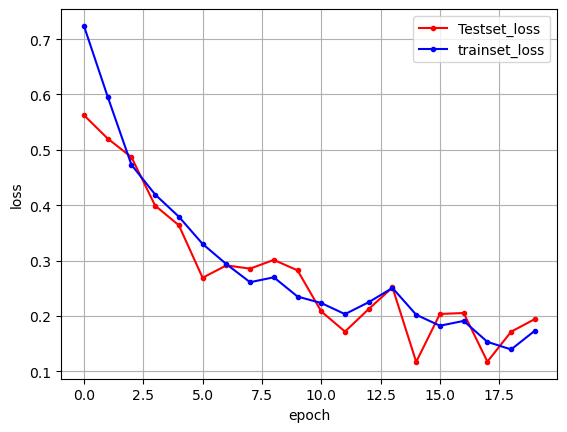

In [40]:
# 검증셋과 학습셋의 오차 저장

y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker = '.', c='red', label = 'Testset_loss')
plt.plot(x_len, y_loss, marker = '.', c='blue', label = 'trainset_loss')

plt.legend(loc = 'best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()